In [12]:
from langchain_core.prompts.chat import (
    BaseMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from typing import Any, List, Optional, Sequence, Tuple, Type, Union
from langchain_core.language_models import BaseLanguageModel
from langchain_core.tools import BaseTool
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.agents.format_scratchpad.openai_functions import (
    format_to_openai_function_messages,
)
from langchain.agents.output_parsers.openai_functions import (
    OpenAIFunctionsAgentOutputParser,
)


def create_openai_ollama_functions_agent(
    llm: BaseLanguageModel, tools: Sequence[BaseTool], prompt: ChatPromptTemplate
) -> Runnable:
    """Create an agent that uses OpenAI function calling.

    Args:
        llm: LLM to use as the agent. Should work with OpenAI function calling,
            so either be an OpenAI model that supports that or a wrapper of
            a different model that adds in equivalent support.
        tools: Tools this agent has access to.
        prompt: The prompt to use. See Prompt section below for more.

    Returns:
        A Runnable sequence representing an agent. It takes as input all the same input
        variables as the prompt passed in does. It returns as output either an
        AgentAction or AgentFinish.

    Example:

        Creating an agent with no memory

        .. code-block:: python

            from langchain_community.chat_models import ChatOpenAI
            from langchain.agents import AgentExecutor, create_openai_functions_agent
            from langchain import hub

            prompt = hub.pull("hwchase17/openai-functions-agent")
            model = ChatOpenAI()
            tools = ...

            agent = create_openai_functions_agent(model, tools, prompt)
            agent_executor = AgentExecutor(agent=agent, tools=tools)

            agent_executor.invoke({"input": "hi"})

            # Using with chat history
            from langchain_core.messages import AIMessage, HumanMessage
            agent_executor.invoke(
                {
                    "input": "what's my name?",
                    "chat_history": [
                        HumanMessage(content="hi! my name is bob"),
                        AIMessage(content="Hello Bob! How can I assist you today?"),
                    ],
                }
            )

    Prompt:

        The agent prompt must have an `agent_scratchpad` key that is a
            ``MessagesPlaceholder``. Intermediate agent actions and tool output
            messages will be passed in here.

        Here's an example:

        .. code-block:: python

            from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", "You are a helpful assistant"),
                    MessagesPlaceholder("chat_history", optional=True),
                    ("human", "{input}"),
                    MessagesPlaceholder("agent_scratchpad"),
                ]
            )
    """
    if "agent_scratchpad" not in prompt.input_variables:
        raise ValueError(
            "Prompt must have input variable `agent_scratchpad`, but wasn't found. "
            f"Found {prompt.input_variables} instead."
        )
    llm_with_tools = llm.bind(functions=[convert_to_openai_function(t) for t in tools])
    agent = (
        RunnablePassthrough.assign(
            agent_scratchpad=lambda x: format_to_openai_function_messages(
                x["intermediate_steps"]
            )
        )
        | prompt
        | llm_with_tools
        | OpenAIFunctionsAgentOutputParser()
    )
    return agent


In [10]:
from langchain_community.tools.polygon.financials import PolygonFinancials
from langchain_community.tools.polygon.last_quote import PolygonLastQuote
from langchain_community.tools.polygon.ticker_news import PolygonTickerNews
from langchain_community.utilities.polygon import PolygonAPIWrapper
from dotenv import load_dotenv
load_dotenv()

polygon = PolygonAPIWrapper()
tools = [
    PolygonLastQuote(api_wrapper=polygon),
    PolygonTickerNews(api_wrapper=polygon),
    PolygonFinancials(api_wrapper=polygon),
    # PolygonAggregates(api_wrapper=polygon),
]

from langchain_core.utils.function_calling import convert_to_openai_function


functions=[convert_to_openai_function(t) for t in tools]
functions


[{'name': 'polygon_last_quote',
  'description': "A wrapper around Polygon's Last Quote API. This tool is useful for fetching the latest price of a stock. Input should be the ticker that you want to query the last price quote for.",
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string'}},
   'required': ['query']}},
 {'name': 'polygon_ticker_news',
  'description': "A wrapper around Polygon's Ticker News API. This tool is useful for fetching the latest news for a stock. Input should be the ticker that you want to get the latest news for.",
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string'}},
   'required': ['query']}},
 {'name': 'polygon_financials',
  'description': "A wrapper around Polygon's Stock Financials API. This tool is useful for fetching fundamental financials from balance sheets, income statements, and cash flow statements for a stock ticker. The input should be the ticker that you want to get the latest fundamental fi

In [28]:
"""1. Define the tools our agent can use"""
import os
from langchain import hub
from langchain.agents import create_openai_functions_agent
# from langchain_openai.chat_models import ChatOpenAI
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_community.chat_models import ChatOllama
from langchain_experimental.llms.ollama_functions import OllamaFunctions

# from langchain_community.tools.polygon.
from langchain_community.tools.polygon.financials import PolygonFinancials
from langchain_community.tools.polygon.last_quote import PolygonLastQuote
from langchain_community.tools.polygon.ticker_news import PolygonTickerNews
from langchain_community.utilities.polygon import PolygonAPIWrapper
from dotenv import load_dotenv
load_dotenv()


from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = [TavilySearchResults(max_results=5)]


prompt = hub.pull("hwchase17/openai-functions-agent")
# llm = ChatOpenAI(model="gpt-4-turbo-preview")
llm = OllamaFunctions(model='mistral:7b-instruct-v0.2-q6_K')

# polygon = PolygonAPIWrapper(polygon_api_key= '5fxxmDYMK4BdAYbuXDBKWRUeTRpQui2k')
# tools = [
#     PolygonLastQuote(api_wrapper=polygon),
#     PolygonTickerNews(api_wrapper=polygon),
#     PolygonFinancials(api_wrapper=polygon),
#     # PolygonAggregates(api_wrapper=polygon),
# ]

# """2. Define agent and helper functions"""
from langchain_core.runnables import RunnablePassthrough
from langchain_core.agents import AgentFinish

# Define the agent
agent_runnable = create_openai_ollama_functions_agent(llm, tavily_tool, prompt)
agent = RunnablePassthrough.assign(
    agent_outcome = agent_runnable
)

# Define the function to execute tools
def execute_tools(data):
    
    agent_action = data.pop('agent_outcome')
    print(agent_action)
    # tool_to_use = {t.name: t for t in tools}[agent_action.tool]
    tool_to_use = {t.name: t for t in tavily_tool}[agent_action.tool]

    observation = tool_to_use.invoke(agent_action.tool_input)
    data['intermediate_steps'].append((agent_action, observation))
    print('\n\n')
    print(data)
    return data

# """3. Define the LangGraph"""
from langgraph.graph import END, Graph

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "exit"
    else:
        return "continue"

workflow = Graph()
workflow.add_node("agent", agent)
workflow.add_node("tools", execute_tools)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "exit": END
    }
)
workflow.add_edge('tools', 'agent')
chain = workflow.compile()


In [29]:
result = chain.invoke({"input": "who is the ceo of tesla?", "intermediate_steps": []})
output = result['agent_outcome'].return_values["output"]
print(output)

tool='tavily_search_results_json' tool_input={'query': 'Who is the CEO of Tesla?'} log="\nInvoking: `tavily_search_results_json` with `{'query': 'Who is the CEO of Tesla?'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who is the CEO of Tesla?"}'}})]



{'input': 'who is the ceo of tesla?', 'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'Who is the CEO of Tesla?'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'Who is the CEO of Tesla?'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who is the CEO of Tesla?"}'}})]), [{'url': 'https://en.wikipedia.org/wiki/Elon_Musk', 'content': 'By this time, however, eight of the 12 children, had already been rescued, the rescuers employing full face masks, oxygen, and anesthesia; consequen

ValueError: Received unsupported message type for Ollama.

In [ ]:

{'input': 'who is the ceo of tesla?', 'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'Who is the CEO of Tesla?'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'Who is the CEO of Tesla?'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who is the CEO of Tesla?"}'}})]), [{'url': 'https://en.wikipedia.org/wiki/Elon_Musk', 'content': 'By this time, however, eight of the 12 children, had already been rescued, the rescuers employing full face masks, oxygen, and anesthesia; consequently, Thai authorities declined to use the submarine.[289] In March 2019, Musk was later one of the 187 people who received various honors conferred by the King of Thailand for involvement in the rescue effort.[293]\nSoon after the rescue, Vernon Unsworth, a British recreational caver who had been exploring the cave for the previous six years and played a key advisory role in the operation, criticized the submarine on CNN as amounting to nothing more than a public relations effort with no chance of success, maintaining that Musk "had no conception of what the cave passage was like" and "can stick his submarine where it hurts". In 2022, a federal probe was launched into possible animal welfare violations by Neuralink.[195]\nIn September 2023, the company was approved to intitiate human trials; the company will conduct a six-year study.[196]\nThe Boring Company\nIn 2017, Musk founded the Boring Company to construct tunnels, and revealed plans for specialized, underground, high-occupancy vehicles that could travel up to 150 miles per hour (240\xa0km/h) and thus circumvent above-ground traffic in major cities.[197][198] Early in 2017, the company began discussions with regulatory bodies and initiated construction of a 30-foot (9.1\xa0m) wide, 50-foot (15\xa0m) long, and 15-foot (4.6\xa0m) deep "test trench" on the premises of SpaceX\'s offices, as that required no permits.[199] The Los Angeles tunnel, less than two miles (3.2\xa0km) in length, debuted to journalists in 2018. At the time, SolarCity was facing liquidity issues.[178] Multiple shareholder groups filed a lawsuit against Musk and Tesla\'s directors, stating that the purchase of SolarCity was done solely to benefit Musk and came at the expense of Tesla and its shareholders.[179][180] Tesla directors settled the lawsuit in January 2020, leaving Musk the sole remaining defendant.[181][182] Two years later, the court ruled in Musk\'s favor.[183]\nNeuralink\nIn 2016, Musk co-founded Neuralink, a neurotechnology startup company, with an investment of $100\xa0million.[184][185] Neuralink aims to integrate the human brain with artificial intelligence (AI) by creating devices that are embedded in the brain to facilitate its merging with machines. At age twelve, Musk sold his BASIC-based game Blastar to PC and Office Technology magazine for approximately $500.[44][45]\nEducation\nMusk attended Waterkloof House Preparatory School, Bryanston High School, and Pretoria Boys High School, from where he graduated.[46] Musk was a good but not exceptional student, earning a 61 in Afrikaans and a B on his senior math certification.[47] Musk applied for a Canadian passport through his Canadian-born mother,[48][49] knowing that it would be easier to immigrate to the United States this way.[50] While waiting for his application to be processed, he attended the University of Pretoria for five months.[51]\nMusk arrived in Canada in June 1989 and lived with a second cousin in Saskatchewan for a year,[52] working odd jobs at a farm and lumber mill.[53] In 1990, he entered Queen\'s University in Kingston, Ontario.[54][55] In January 2023, Musk was recognized by Guinness World Records for experiencing the "largest loss of personal fortune in history" with regards to his financial losses since November 2021, which Guinness quoted a Forbes estimate of $182 billion.[334]\nMusk\'s personal wealth is managed by his family office called Excession LLC, formed in 2016 and run by Jared Birchall.[335][261]\nSources of wealth\nAround 75% of Musk\'s wealth was derived from Tesla stock in November 2020,[327] a proportion that fell to about 37% as of December 2022,[f] after selling nearly $40 billion in company shares since late 2021.[336] Musk does not receive a salary from Tesla; he agreed with the board in 2018 to a compensation plan that ties his personal earnings to Tesla\'s valuation and revenue.[325]'}, {'url': 'https://ir.tesla.com/corporate/elon-musk', 'content': 'Elon is Technoking of Tesla and has served as our Chief Executive Officer since October 2008 and as a member of the Board since April 2004. Elon has also served as Chief Executive Officer, Chief Technology Officer and Chairman of Space Exploration Technologies Corporation, an advanced rocket and spacecraft manufacturing and services company ("SpaceX "), since May 2002, and served as ...'}, {'url': 'https://www.biography.com/business-leaders/elon-musk', 'content': 'If you see something that doesn\'t look right,contact us!\nCITATION INFORMATION\nQUOTES\nEntrepreneurs\nSuge Knight\nJimmy Buffett\nJimmy Dean\nRupert Murdoch\nEnzo Ferrari\nThe Tragic True Story of the ‘Ferrari’ Movie\nWho Is Music Mogul Scooter Braun?\nSelena Gomez\nThe 15 Richest Actors in the World\nHow Mattel Cofounder Ruth Handler Created Barbie\nBarbie\nThe True, Disputed Story Behind “Flamin’ Hot”\nA Part of Hearst Digital Media\nWe may earn commission from links on this page, but we only recommend products we back.\n Nonprofit Work\nThe boundless potential of space exploration and the preservation of the future of the human race have become the cornerstones of Musk\'s abiding interests, and toward these, he has founded the Musk Foundation, which is dedicated to space exploration and the discovery of renewable and clean energy sources.\n While this represented significant progress for the Starlink venture, the appearance of these bright orbiters in the night sky, with the potential of thousands more to come, worried astronomers who felt that a proliferation of satellites would increase the difficulty of studying distant objects in space.\n Later in the month, after it was reported that the State of California wouldn\'t accept a name with a number, the couple said they were changing their son\'s name to "X Æ A-Xii."\nMusk and Grimes welcomed their second child, a daughter named Exa Dark Sideræl Musk, in December 2021. By 2008, SpaceX was well established, and NASA awarded the company the contract to handle cargo transport for the International Space Station—with plans for astronaut transport in the future—in a move to replace NASA’s own space shuttle missions.\n'}, {'url': 'https://www.businessinsider.com/tesla-ceo-elon-musk?op=1', 'content': 'Tesla Roadster in space\nThe Falcon Heavy, the successor to the Falcon 9 and the most powerful rocket SpaceX has built to date, completed a successful maiden launch in February 2018. "We really wanted to get the public here to wonder, to get excited about the possibility of something new happening in space — of the space frontier getting pushed forward," Musk told an audience at the 2018 South by Southwest conference. Though, Autopilot has generated its fair share of lawsuits, as well as investigations from the National Highway Traffic Safety Administration over the years.\n2016: SolarCity and The Boring Company\nIn late 2016, Tesla bought SolarCity in a $2.6 billion deal. The \'Technoking\' sets his sights on Twitter\nIn 2022, Musk started buying up shares of Twitter and later turned down an offer to join the board in favor of buying Twitter outright for $44 billion.\n The bullies threw Musk down a set of stairs and beat him until he blacked out, as detailed in Ashlee Vance\'s book "Elon Musk: Tesla, SpaceX, and the Quest for a Fantastic Future."'}, {'url': 'https://www.tesla.com/elon-musk', 'content': "Elon Musk. Elon Musk co-founded and leads Tesla, SpaceX, Neuralink and The Boring Company. As the co-founder and CEO of Tesla, Elon leads all product design, engineering and global manufacturing of the company's electric vehicles, battery products and solar energy products. Since the company's inception in 2003, Tesla's mission has been to ..."}])]}

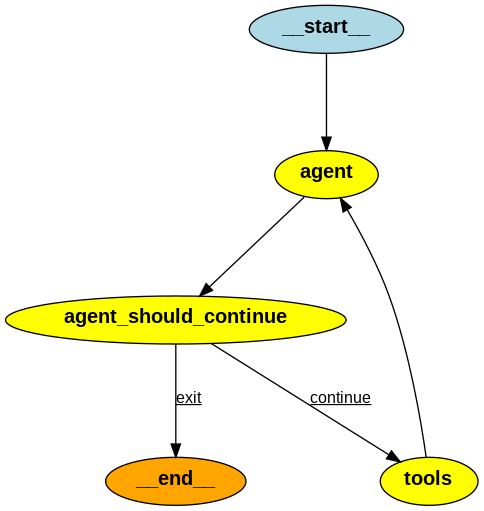

In [21]:

from IPython.display import Image

Image(chain.get_graph().draw_png())
